In [282]:
# Imports
import pandas as pd
from typing import Dict
import seaborn as sns

In [283]:
# File paths
NEW_BUILD_CSV: str = "Data/Neubauwohnungen_Zürich.csv"
TAXABLE_INCOME_CSV: str = "Data/Vermögen_Stadt_zürich.csv"
EQUIVALIZED_INCOME_CSV: str = "Data/Haushaltsäquivalenz-Einkommen.csv"

In [284]:
NEW_BUILD_COLMAP: Dict[str, str] = {
    # grouping
    "KreisLang": "district_name",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    # metrics
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "num_rental_apartment",  
}

TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "SteuerEinkommen_p50": "taxable_income_p50",  # median taxable income (per year)
}

EQUIVALIZED_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "aequEK_p50": "equivalized_income_p50",  # median equivalized income (per year)
}

In [285]:
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Rename the CSV files"""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [286]:
def aggregate_new_build_by_district(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by district and five-year period.
    Logic matches the original:
      - sums of retirees, children, living area, rooms, appartements, population, rental_appartments
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["district_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda x: (x == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [287]:
def aggregate_new_build_by_quarter(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by quarter and five-year period.
    Same metrics and logic as the district-level aggregation.
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["quarter_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [288]:
def aggregate_taxable_income_by_district(
    csv_path: str = TAXABLE_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to years >= 2015, then group by district and compute the mean of the
    annual median taxable incomes (p50). Matches the original logic exactly.
    """
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [289]:
def aggregate_equivalized_income_by_district(
    csv_path: str = EQUIVALIZED_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to 2015 <= year < 2019, then group by district and compute the mean
    of the annual median equivalized incomes (p50). Matches original logic.
    """
    df = load_and_rename(csv_path, EQUIVALIZED_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_equivalized_income=("equivalized_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [290]:
def build_join_df(
    taxable_income_by_district: pd.DataFrame,
    new_build_by_district: pd.DataFrame,
    equivalized_income_by_district: pd.DataFrame,
) -> pd.DataFrame:
    """
    Reproduce the two-step LEFT/RIGHT merge from the original code:
      1) LEFT join taxable_income_by_district with new_build_by_district on district
      2) RIGHT join result with equivalized_income_by_district on district
    The final 'right' join ensures all districts from the taxable/new_build join
    are kept (as per original).
    """
    join_left = pd.merge(
        taxable_income_by_district,
        new_build_by_district,
        on="district_name",
        how="left",
    )

    joined = pd.merge(
        equivalized_income_by_district,
        join_left,
        on="district_name",
        how="right",
    )
    return joined


In [291]:
# New-build aggregations (district & quarter)
new_build_by_quarter = aggregate_new_build_by_quarter()
new_build_by_district = aggregate_new_build_by_district()

# Income aggregations
taxable_income_by_district = aggregate_taxable_income_by_district()
equivalized_income_by_district = aggregate_equivalized_income_by_district()

# Final join
joined_df = build_join_df(
    taxable_income_by_district=taxable_income_by_district,
    new_build_by_district=new_build_by_district,
    equivalized_income_by_district=equivalized_income_by_district,
)

# View results
(new_build_by_quarter)
(taxable_income_by_district)
(equivalized_income_by_district)
(joined_df)

,district_name,median_equivalized_income,median_taxable_income,five_year_period,num_retirees,num_children,living_area,num_rooms,num_dwellings,population_total,rental_dwellings
0,Kreis 1,65.257037,77.108333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kreis 10,56.927500,64.533333,2015–2019,138.0,521.0,81799.0,527.0,878.0,2051.0,120.0
2,Kreis 10,56.927500,64.533333,2020–2024,53.0,207.0,39621.0,425.0,446.0,963.0,88.0
3,Kreis 11,50.025250,52.108333,2015–2019,282.0,645.0,152628.0,1127.0,1694.0,3545.0,250.0
4,Kreis 11,50.025250,52.108333,2020–2024,309.0,989.0,193924.0,974.0,2389.0,5056.0,247.0
5,Kreis 12,39.501111,41.454167,2015–2019,402.0,1003.0,157775.0,516.0,1779.0,4327.0,154.0
6,Kreis 12,39.501111,41.454167,2020–2024,216.0,197.0,45411.0,402.0,582.0,1145.0,107.0
7,Kreis 2,58.973500,64.537500,2015–2019,218.0,921.0,133098.0,714.0,1412.0,3506.0,163.0
8,Kreis 2,58.973500,64.537500,2020–2024,178.0,824.0,137466.0,645.0,1623.0,3631.0,165.0
9,Kreis 3,51.827000,54.562500,2015–2019,192.0,425.0,62254.0,499.0,740.0,1722.0,129.0


In [395]:
import pandas as pd
import numpy as np


data = pd.read_csv("Data/Wohnungen_Zürich.csv")
df_3 = data[["KreisLang", "KreisSort", "AnzZimmerLevel1Cd_noDM", "BauperiodeLevel1Lang","BauperiodeLevel1Sort","AnzWhgStat","Wohnflaeche"]].copy()

df_3 = df_3.groupby(["KreisLang", "KreisSort", "BauperiodeLevel1Lang", "BauperiodeLevel1Sort"]).aggregate({
    "AnzZimmerLevel1Cd_noDM": "sum",
    "AnzWhgStat": "sum",
    "Wohnflaeche": "sum"   
}).reset_index()

df_3 = df_3.rename(columns={
    "KreisLang": "district_name",
    "KreisSort": "district_sort",
    "BauperiodeLevel1Lang": "building_period",
    "BauperiodeLevel1Sort": "building_period_sort",
    "AnzZimmerLevel1Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "Wohnflaeche": "living_area"
})

df_3.sort_values(["num_appartments"], inplace=True)
df_3["building_period"].unique()


array(['2010 - 2019', '2000 - 2009', '1920 - 1929', '1900 - 1909',
       '1940 - 1949', '1893 - 1899', '1910 - 1919', '2020 - 2029',
       '1950 - 1959', '1930 - 1939', 'Vor 1893', '1960 - 1969',
       '1980 - 1989', '1990 - 1999', '1970 - 1979'], dtype=object)

C:\Users\livio\AppData\Local\Temp\ipykernel_2052\413631802.py:148: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



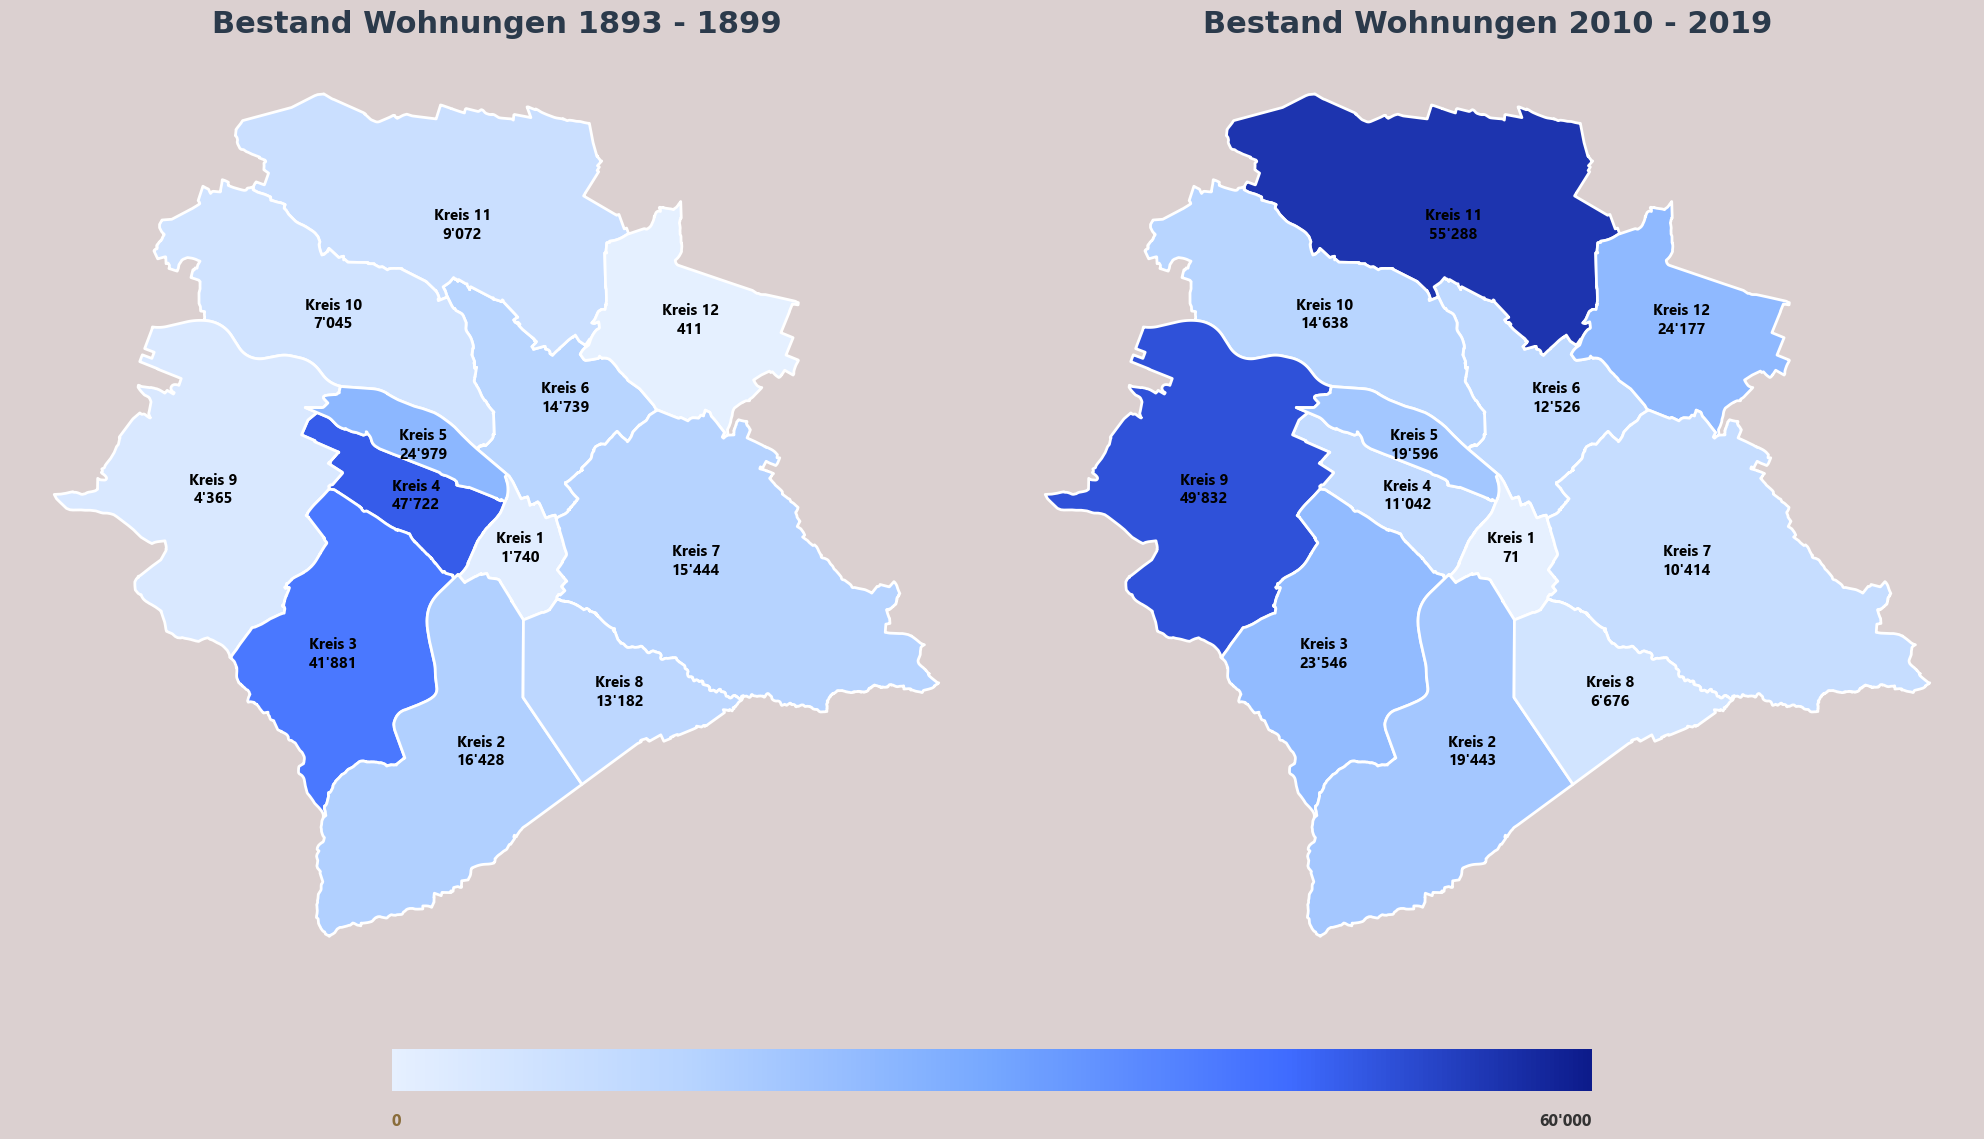

In [410]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------------
# Custom Farbschema im Stil der Vorlage
# ------------------------------------
colors = [
    "#e6f0ff",  # sehr helles Blau
    "#b7d4ff",  # pastell-blau
    "#76a8ff",  # mittelblau
    "#3f6bff",  # kräftigeres Blau
    "#0d1b8b"   # dunkelblau
]

custom_cmap = LinearSegmentedColormap.from_list("custom_blue", colors)

# ------------------------------------
# GeoJSON laden
# ------------------------------------
gdf = gpd.read_file("kreise_zuerich.geojson")

# ------------------------------------
# Deine Daten vorbereiten
# ------------------------------------
df_building_old = df_3[df_3["building_period_sort"] == 2]
df_building_old = df_building_old[["district_name", "num_appartments"]]

df_building_new = df_3[df_3["building_period_sort"] == 14]
df_building_new = df_building_new[["district_name", "num_appartments"]]

# GeoJSON + DataFrame verbinden
gdf_merged_old = gdf.merge(df_building_old, left_on="bezeichnung", right_on="district_name")
gdf_merged_new = gdf.merge(df_building_new, left_on="bezeichnung", right_on="district_name")

# Koordinaten für Labels
gdf_merged_old["coords"] = gdf_merged_old.geometry.representative_point().apply(lambda p: (p.x, p.y))
gdf_merged_new["coords"] = gdf_merged_new.geometry.representative_point().apply(lambda p: (p.x, p.y))

# ------------------------------------
# Plot erstellen
# ------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
fig.patch.set_facecolor("#DBD0D0")

# Gemeinsame Norm für beide Karten
norm = mpl.colors.Normalize(vmin=0, vmax=60000)

# ------------------------------------
# Karte 1 – Altbau
# ------------------------------------
gdf_merged_old.plot(
    ax=ax1,
    column="num_appartments",
    cmap=custom_cmap,
    norm=norm,
    linewidth=2.0,
    edgecolor="white",
)
ax1.set_axis_off()
ax1.set_title(
    "Bestand Wohnungen 1893 - 1899",
    fontsize=22,
    fontweight="bold",
    fontfamily="DejaVu Sans",
    pad=14
)

# Labels
for _, row in gdf_merged_old.iterrows():
    x, y = row["coords"]
    value_str = format(int(row["num_appartments"]), ",").replace(",", "'")
    label_text = f'{row["bezeichnung"]}\n{value_str}'
    ax1.text(
        x, y, label_text,
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )

# ------------------------------------
# Karte 2 – Neubau
# ------------------------------------
gdf_merged_new.plot(
    ax=ax2,
    column="num_appartments",
    cmap=custom_cmap,
    norm=norm,
    linewidth=2.0,
    edgecolor="white",
)
ax2.set_axis_off()
ax2.set_title(
    "Bestand Wohnungen 2010 - 2019",
    fontsize=22,
    fontweight="bold",
    fontfamily="DejaVu Sans",
    pad=14
)

# Labels
for _, row in gdf_merged_new.iterrows():
    x, y = row["coords"]
    value_str = format(int(row["num_appartments"]), ",").replace(",", "'")
    label_text = f'{row["bezeichnung"]}\n{value_str}'
    ax2.text(
        x, y, label_text,
        ha="center", va="center",
        fontsize=11, fontweight="bold", color="black"
    )

# ------------------------------------
# Moderne Legende MIT runden Ecken
# ------------------------------------
cbar_ax = fig.add_axes([0.20, 0.05, 0.60, 0.035])  # genau mittig

# Verlauf erzeugen
gradient = np.linspace(0, 1, 256).reshape(1, -1)

# Custom Colorbar
cbar_ax.imshow(
    gradient,
    aspect="auto",
    cmap=custom_cmap,
    extent=[0, 60000, 0, 1]
)

# Achsen ausblenden
cbar_ax.set_yticks([])
cbar_ax.set_xticks([])

# Links und rechts Werte setzen
cbar_ax.text(
    0, -0.7, "0", ha="left", va="center",
    fontsize=12, color="#8a6d3b", fontweight="bold"
)
cbar_ax.text(
    60000, -0.7, "60'000", ha="right", va="center",
    fontsize=12, color="#333", fontweight="bold"
)

# Rahmen entfernen
for spine in cbar_ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(rect=[0, 0.12, 1, 0.94])
plt.show()


In [403]:
test = gdf_merged_old["num_appartments"].sum()
test

gdf_merged_new["num_appartments"].sum()

np.int64(247249)

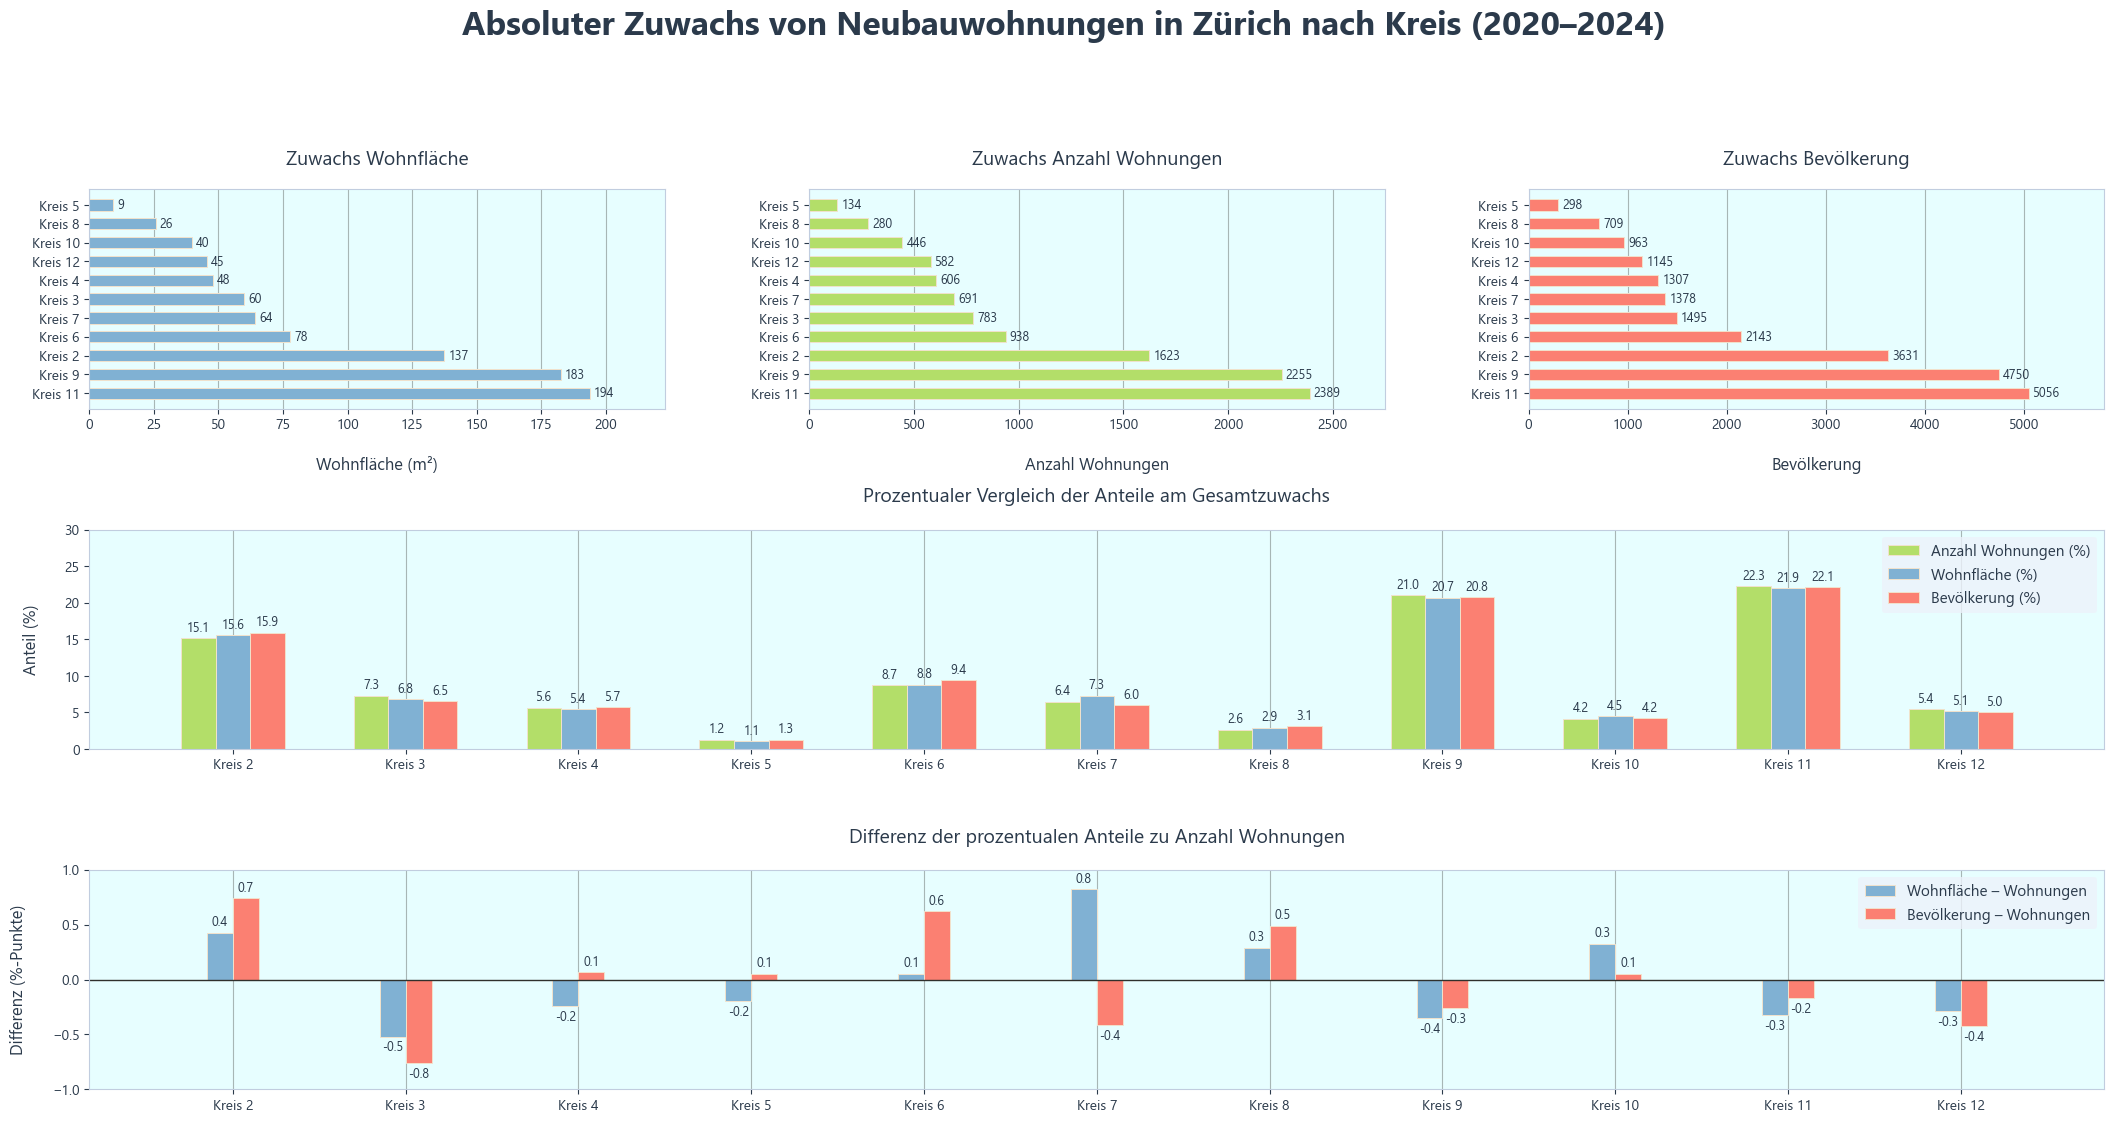

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# ============================================================
# Globaler Stil – Blue Harmony + professionelle Schrift
# ============================================================
plt.rcParams.update({
    "font.family": "Segoe UI",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "text.color": "#2B3A4B",
    "axes.labelcolor": "#2B3A4B",
    "axes.titlecolor": "#2B3A4B",
    "xtick.color": "#2B3A4B",
    "ytick.color": "#2B3A4B",
    "legend.edgecolor": "none",
})

figure_bg = "#ffffff"
axes_bg = "#e7feff"


color_living = "#80b1d3"
color_dwell  = "#b3de69"
color_pop    = "#fb8072"

edge_color   = "#f1e2cc"
grid_color   = "#30302c"

# ============================================================
# Datenvorbereitung
# ============================================================
filtered = joined_df[joined_df["five_year_period"] == "2020–2024"]

df_3 = filtered[
    ["district_name", "living_area", "num_dwellings",
     "population_total", "five_year_period"]
].copy()

df_3["district_nr"] = df_3["district_name"].str.extract(r"Kreis (\d+)").astype(int)
df_3 = df_3.sort_values("district_nr")

# Basis-Achsenreihenfolge (für Prozent- und Differenzplots)
x = df_3["district_name"]

# Absolute Werte
living_abs    = df_3["living_area"] / 1000
dwellings_abs = df_3["num_dwellings"]
pop_abs       = df_3["population_total"]

# ============================================================
# Sortierte Daten für die oberen 3 Diagramme
# ============================================================

# Wohnfläche sortiert
df_living_sorted = df_3.sort_values("living_area", ascending=False)
x1 = df_living_sorted["district_name"]
living_abs_sorted = df_living_sorted["living_area"] / 1000

# Anzahl Wohnungen sortiert
df_dwell_sorted = df_3.sort_values("num_dwellings", ascending=False)
x2 = df_dwell_sorted["district_name"]
dwellings_abs_sorted = df_dwell_sorted["num_dwellings"]

# Bevölkerung sortiert
df_pop_sorted = df_3.sort_values("population_total", ascending=False)
x3 = df_pop_sorted["district_name"]
pop_abs_sorted = df_pop_sorted["population_total"]

# ============================================================
# Figure Setup
# ============================================================
fig1 = plt.figure(figsize=(26, 12))
fig1.patch.set_facecolor(figure_bg)

fig1.suptitle(
    "Absoluter Zuwachs von Neubauwohnungen in Zürich nach Kreis (2020–2024)",
    fontsize=24,
    fontweight="bold",
    y=1.01
)

# 3 Plot-Reihen
gs = gridspec.GridSpec(3, 3, figure=fig1)

ax_abs4 = fig1.add_subplot(gs[1, :])     # Prozent-Plot
ax_abs1 = fig1.add_subplot(gs[0, 0])     
ax_abs2 = fig1.add_subplot(gs[0, 1])
ax_abs3 = fig1.add_subplot(gs[0, 2])

ax_diff = fig1.add_subplot(gs[2, :], sharex=ax_abs4)

# ============================================================
# Helper: Achsenformat
# ============================================================
def format_axis(ax):
    ax.set_facecolor(axes_bg)
    ax.grid(axis="x", alpha=0.35, color=grid_color, linewidth=0.8)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color("#C1CDDf")
        spine.set_linewidth(0.8)

# ============================================================
# Obere Plots: Horizontale Balken (links → rechts)
# ============================================================
bar_height = 0.6

# --- Wohnfläche ---
bars1 = ax_abs1.barh(
    x1, living_abs_sorted,
    bar_height,
    color=color_living, edgecolor=edge_color, linewidth=0.7
)
ax_abs1.set_title("Zuwachs Wohnfläche", pad=18)
ax_abs1.set_xlabel("Wohnfläche (m²)", labelpad=18)
ax_abs1.bar_label(bars1, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs1)
ax_abs1.set_xlim(0, living_abs_sorted.max() * 1.15)

# --- Anzahl Wohnungen ---
bars2 = ax_abs2.barh(
    x2, dwellings_abs_sorted,
    bar_height,
    color=color_dwell, edgecolor=edge_color, linewidth=0.7
)
ax_abs2.set_title("Zuwachs Anzahl Wohnungen", pad=18)
ax_abs2.set_xlabel("Anzahl Wohnungen", labelpad=18)
ax_abs2.bar_label(bars2, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs2)
ax_abs2.set_xlim(0, dwellings_abs_sorted.max() * 1.15)

# --- Bevölkerung ---
bars3 = ax_abs3.barh(
    x3, pop_abs_sorted,
    bar_height,
    color=color_pop, edgecolor=edge_color, linewidth=0.7
)
ax_abs3.set_title("Zuwachs Bevölkerung", pad=18)
ax_abs3.set_xlabel("Bevölkerung", labelpad=18)
ax_abs3.bar_label(bars3, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs3)
ax_abs3.set_xlim(0, pop_abs_sorted.max() * 1.15)

# ============================================================
# Prozentwerte – Reihenfolge: Wohnungen – Wohnfläche – Bevölkerung
# ============================================================
y_living_pct = living_abs    / living_abs.sum()    * 100
y_dwell_pct  = dwellings_abs / dwellings_abs.sum() * 100
y_pop_pct    = pop_abs       / pop_abs.sum()       * 100

x_pos = np.arange(len(x))
bar_width_bottom = 0.2

bars_y2 = ax_abs4.bar(
    x_pos - bar_width_bottom,
    y_dwell_pct,
    bar_width_bottom,
    color=color_dwell,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Anzahl Wohnungen (%)",
)

bars_y1 = ax_abs4.bar(
    x_pos,
    y_living_pct,
    bar_width_bottom,
    color=color_living,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Wohnfläche (%)",
)

bars_y3 = ax_abs4.bar(
    x_pos + bar_width_bottom,
    y_pop_pct,
    bar_width_bottom,
    color=color_pop,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Bevölkerung (%)",
)

ax_abs4.set_title("Prozentualer Vergleich der Anteile am Gesamtzuwachs", pad=20)
ax_abs4.set_ylabel("Anteil (%)", labelpad=18)
ax_abs4.set_xticks(x_pos)
ax_abs4.set_xticklabels(x, ha="center")

legend = ax_abs4.legend(loc="upper right", frameon=True)
legend.get_frame().set_facecolor("#EDF2FA")

ax_abs4.bar_label(bars_y2, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y1, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y3, padding=3, fmt="%.1f", fontsize=9)

format_axis(ax_abs4)
ax_abs4.set_ylim(0, 30)

# ============================================================
# Differenzen – Wohnfläche – Bevölkerung relativ zu Wohnungen
# ============================================================
diff_living = y_living_pct - y_dwell_pct
diff_pop    = y_pop_pct    - y_dwell_pct

bar_width_diff = 0.15

bars_diff_living = ax_diff.bar(
    x_pos - bar_width_diff / 2,
    diff_living,
    bar_width_diff,
    color=color_living,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Wohnfläche – Wohnungen",
)

bars_diff_pop = ax_diff.bar(
    x_pos + bar_width_diff / 2,
    diff_pop,
    bar_width_diff,
    color=color_pop,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Bevölkerung – Wohnungen",
)

ax_diff.set_title("Differenz der prozentualen Anteile zu Anzahl Wohnungen", pad=20)
ax_diff.set_ylabel("Differenz (%-Punkte)", labelpad=18)

ax_diff.set_xticks(x_pos)
ax_diff.set_xticklabels(x, ha="center")
ax_diff.set_ylim(-1, 1)
ax_diff.axhline(0, color=grid_color, linewidth=1)

ax_diff.bar_label(bars_diff_living, padding=3, fmt="%.1f", fontsize=9)
ax_diff.bar_label(bars_diff_pop,    padding=3, fmt="%.1f", fontsize=9)

format_axis(ax_diff)

legend_diff = ax_diff.legend(loc="upper right", frameon=True)
legend_diff.get_frame().set_facecolor("#EDF2FA")

# ============================================================
# Layout
# ============================================================
plt.subplots_adjust(hspace=0.55, wspace=0.25, top=0.86)
plt.show()
